### EDA INICIAL

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
# Ruta del directorio:
directorio = r'C:\Users\Usuario\Desktop\IT Academy\03. Simulaçao Empresarial\Clone\ProjecteData\Equip_19\Data\INE'

# Lista para almacenar todos los dataframes temporales
lista_dataframes = []

# Función para leer archivo con diferentes codificaciones:
def leer_archivo_con_codificacion(ruta_archivo):
    codificaciones = ['latin1', 'cp1252', 'utf-8']
    for codificacion in codificaciones:
        try:
            with open(ruta_archivo, 'r', encoding=codificacion) as f:
                primera_linea = f.readline().strip()
                segunda_linea = f.readline().strip()
            print(f"  Encabezado detectado: {primera_linea}")
            print(f"  Segunda línea detectada: {segunda_linea}")

            # Verificar si el encabezado contiene punto y coma
            if ';' in primera_linea:
                df = pd.read_csv(ruta_archivo, encoding=codificacion, delimiter=';', header=0)
                print(f"  Leído con éxito usando codificación '{codificacion}' y delimitador ';'.")
                return df
            else:
                df = pd.read_csv(ruta_archivo, encoding=codificacion, header=0)
                print(f"  Leído con éxito usando codificación '{codificacion}' y delimitador por defecto (,).")
                return df
        except UnicodeDecodeError:
            print(f"  Fallo con codificación '{codificacion}'. Intentando la siguiente...")
            continue
        except pd.errors.ParserError as e:
            print(f"  Error de parseo con codificación '{codificacion}': {e}. Intentando la siguiente...")
            continue
    raise Exception(f"No se pudo leer el archivo {ruta_archivo} con ninguna de las codificaciones probadas.")

# Recorrer todos los archivos en el directorio y subdirectorios
for raiz, subdirectorios, archivos in os.walk(directorio):
    for archivo in archivos:
        # Filtrar solo archivos CSV
        if archivo.lower().endswith('.csv'):
            nombre_base = os.path.splitext(archivo)[0]
            partes_nombre = nombre_base.split('_')

            try:
                tipo_acomodacion = partes_nombre[0]
                variable = partes_nombre[1]
                ano = int(partes_nombre[2])
            except (IndexError, ValueError):
                print(f"Advertencia: Nombre de archivo '{archivo}' no tiene el formato esperado. Se omite.")
                continue

            ruta_archivo = os.path.join(raiz, archivo)

            try:
                df_temp = leer_archivo_con_codificacion(ruta_archivo)
                primera_columna = df_temp.columns[0] # Tomamos la primera columna

                if ';' in primera_columna and len(df_temp.columns) == 1:
                    print(f"  Corrección: Solo 1 columna detectada, releyendo con delimitador ';'.")
                    df_temp = pd.read_csv(ruta_archivo, encoding='latin1', delimiter=';', header=0)
                    print(f"  Releído con éxito. Columnas: {list(df_temp.columns)}")

                # Limpiar posibles espacios en blanco en los nombres de columnas
                df_temp.columns = [col.strip() for col in df_temp.columns]

                #  Metodología y estructura del archivo:
                print(f"    Columnas encontradas en {archivo}: {list(df_temp.columns)}")

                # Verificar las columnas esperadas para HOTELES (EOH)
                columnas_esperadas_hoteles = {'Provincias', 'País de residencia', 'Meses', 'Total'}

                if columnas_esperadas_hoteles.issubset(set(df_temp.columns)):
                    # Estructura de HOTELES (EOH) encontrada
                    print(f"    Estructura de HOTELES detectada en {archivo}.")
                    # Renombrar las columnas al estándar                    
                    df_temp.rename(columns={
                        'Provincias': 'provincia',
                        'País de residencia': 'pais_residencia',
                        'Meses': 'mes',
                        'Total': 'valor'
                    }, inplace=True)

                    # Convertir la columna 'valor' a tipo numérico (float)
                    df_temp['valor'] = pd.to_numeric(
                        df_temp['valor'].astype(str).str.replace(',', '.', regex=False),
                        errors='coerce'
                    )

                    # Añadir las columnas de identificación extraídas del nombre del archivo
                    df_temp['año'] = ano
                    df_temp['tipo_acomodacion'] = tipo_acomodacion

                    # CAMBIO: total_pernoctaciones pasa a media_pernoctaciones
                    if variable == 'pernoctaciones':
                        df_temp['media_pernoctaciones'] = df_temp['valor']
                        df_temp['total_viajeros'] = pd.NA
                    elif variable == 'viajeros':
                        df_temp['media_pernoctaciones'] = pd.NA
                        df_temp['total_viajeros'] = df_temp['valor']
                    else:
                        print(f"  Advertencia: Variable desconocida '{variable}' en {archivo}.")
                        df_temp['media_pernoctaciones'] = pd.NA
                        df_temp['total_viajeros'] = pd.NA

                # Si no es de hoteles, verificar las columnas esperadas para APARTAMENTOS (EOAP)
                else: # No es de hoteles, asumimos que podría ser de apartamentos
                    prov_cols = [col for col in df_temp.columns if 'Provinci' in col]
                    mes_cols = [col for col in df_temp.columns if 'Mes' in col]
                    total_cols = [col for col in df_temp.columns if 'Total' in col]

                    if len(prov_cols) >= 1 and len(mes_cols) >= 1 and len(total_cols) >= 1:
                        col_provincia = prov_cols[0]
                        col_mes = mes_cols[0]
                        col_total = total_cols[0]

                        print(f"    Estructura de APARTAMENTOS detectada.")

                        # Renombrar las columnas al estándar usando las encontradas
                        df_temp.rename(columns={
                            col_provincia: 'provincia',
                            col_mes: 'mes',
                            col_total: 'valor'
                        }, inplace=True)

                        # Convertir la columna 'valor' a tipo numérico (float)
                        df_temp['valor'] = pd.to_numeric(
                            df_temp['valor'].astype(str).str.replace(',', '.', regex=False),
                            errors='coerce'
                        )

                        # Agregar columna 'País de residencia' con valor NA para apartamentos
                        df_temp['pais_residencia'] = pd.NA

                        # Añadir las columnas de identificación extraídas del nombre del archivo
                        df_temp['año'] = ano
                        df_temp['tipo_acomodacion'] = tipo_acomodacion

                        # Crear las nuevas columnas 'media_pernoctaciones' y 'total_viajeros'
                        if variable == 'pernoctaciones':
                            df_temp['media_pernoctaciones'] = df_temp['valor']
                            df_temp['total_viajeros'] = pd.NA
                        elif variable == 'viajeros':
                            df_temp['media_pernoctaciones'] = pd.NA
                            df_temp['total_viajeros'] = df_temp['valor']
                        else:
                            df_temp['media_pernoctaciones'] = pd.NA
                            df_temp['total_viajeros'] = pd.NA
                    else:
                        print(f"  Error: Archivo {archivo} no contiene las columnas requeridas.")
                        continue

                # Reordenar las columnas para mayor claridad (asegurando el orden deseado)
                columnas_finales = [
                    'año', 'mes', 'tipo_acomodacion',
                    'provincia', 'pais_residencia',
                    'media_pernoctaciones', 'total_viajeros'
                ]
                # Asegurarse de que todas las columnas finales estén presentes
                for col in columnas_finales:
                    if col not in df_temp.columns:
                        print(f"  Advertencia: Añadiendo columna faltante '{col}'.")
                        df_temp[col] = pd.NA

                df_temp = df_temp[columnas_finales]

                # Agregar el dataframe temporal a la lista
                lista_dataframes.append(df_temp)

                print(f"  Procesado correctamente. Filas: {len(df_temp)}")

            except Exception as e:
                print(f"  Error general al procesar {archivo}: {e}")


In [ ]:
# Combinar todos los dataframes de la lista en uno solo
if lista_dataframes:
    df_final = pd.concat(lista_dataframes, ignore_index=True)

    # Guardar el dataframe final:
    nombre_archivo_salida = 'datos_INE_turismo_consolidados.csv'
    df_final.to_csv(nombre_archivo_salida, index=False, encoding='utf-8')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22552\3347947167.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat(lista_dataframes, ignore_index=True)


In [8]:
df_final.head()

,año,mes,tipo_acomodacion,provincia,pais_residencia,media_pernoctaciones,total_viajeros
0,2015,Enero,apartamentos,"Balears, Illes",NaN,7.00,NaN
1,2015,Febrero,apartamentos,"Balears, Illes",NaN,6.91,NaN
2,2015,Marzo,apartamentos,"Balears, Illes",NaN,7.06,NaN
3,2015,Abril,apartamentos,"Balears, Illes",NaN,6.26,NaN
4,2015,Mayo,apartamentos,"Balears, Illes",NaN,6.11,NaN


In [9]:
df_final.tail()

,año,mes,tipo_acomodacion,provincia,pais_residencia,media_pernoctaciones,total_viajeros
31831,2021,Agosto,hoteles,46 Valencia/València,Países africanos,NaN,2.375
31832,2021,Septiembre,hoteles,46 Valencia/València,Países africanos,NaN,1.569
31833,2021,Octubre,hoteles,46 Valencia/València,Países africanos,NaN,1.247
31834,2021,Noviembre,hoteles,46 Valencia/València,Países africanos,NaN,1.095
31835,2021,Diciembre,hoteles,46 Valencia/València,Países africanos,NaN,1.488


In [26]:
df_final.columns

Index(['año', 'mes', 'tipo_acomodacion', 'provincia', 'pais_residencia',
       'total_pernoctaciones', 'total_viajeros'],
      dtype='object')

In [27]:
df_final.isnull().sum().sort_values(ascending=False)


total_pernoctaciones    30082
total_viajeros           4123
pais_residencia          1764
tipo_acomodacion            0
mes                         0
año                         0
provincia                   0
dtype: int64

In [28]:
# COMPROBACIÓN FILAS DUPLICADAS
duplicados = df_final.duplicated()
duplicados.sum()

np.int64(9)

In [32]:
# Las filas duplicadas --- REVISAR
filas_duplicadas = df_final[df_final.duplicated(keep=False)]
filas_duplicadas

,año,mes,tipo_acomodacion,provincia,pais_residencia,total_pernoctaciones,total_viajeros
16260,2017,Enero,hoteles,Girona,NaN,1.82,NaN
16272,2017,Enero,hoteles,Girona,NaN,1.82,NaN
16719,2020,Abril,hoteles,"07 Balears, Illes",NaN,0.00,NaN
16731,2020,Abril,hoteles,"07 Balears, Illes",NaN,0.00,NaN
16743,2020,Abril,hoteles,08 Barcelona,NaN,0.00,NaN
16755,2020,Abril,hoteles,08 Barcelona,NaN,0.00,NaN
16767,2020,Abril,hoteles,17 Girona,NaN,0.00,NaN
16779,2020,Abril,hoteles,17 Girona,NaN,0.00,NaN
16791,2020,Abril,hoteles,28 Madrid,NaN,0.00,NaN
16803,2020,Abril,hoteles,28 Madrid,NaN,0.00,NaN


## Distribuición de las métricas (prenotaciones, provincia y pais de procedencia)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17600\3037990001.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pernoctaciones_por_provincia, x='total_pernoctaciones', y='provincia', palette='viridis')


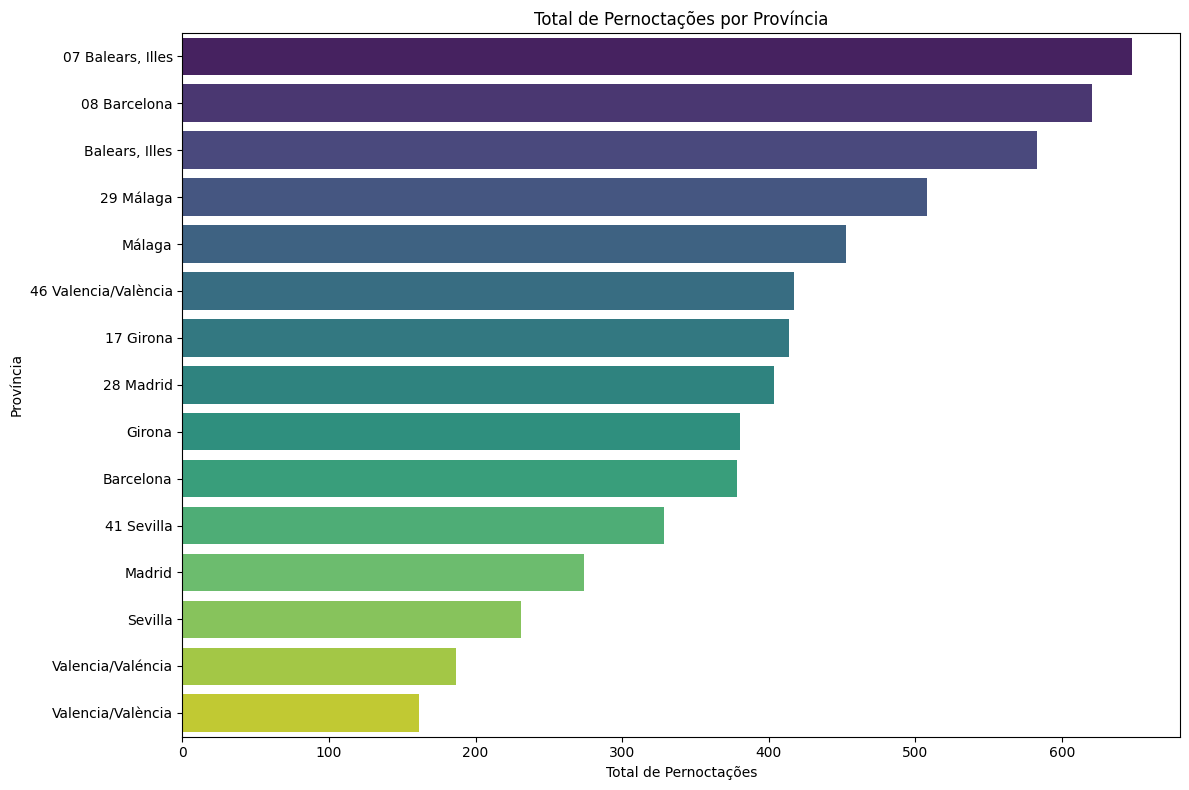

In [34]:

colunas_requeridas = ['provincia', 'pais_residencia', 'total_pernoctaciones', 'total_viajeros']
for col in colunas_requeridas:
    if col not in df_final.columns:
        print(f"Erro: Coluna '{col}' não encontrada no df_final.")

# Gráfico 1: Distribuição de Pernoctações por Província
pernoctaciones_por_provincia = df_final.groupby('provincia')['total_pernoctaciones'].sum().reset_index()
pernoctaciones_por_provincia = pernoctaciones_por_provincia.dropna(subset=['total_pernoctaciones'])
pernoctaciones_por_provincia['total_pernoctaciones'] = pd.to_numeric(pernoctaciones_por_provincia['total_pernoctaciones'], errors='coerce')
pernoctaciones_por_provincia = pernoctaciones_por_provincia.dropna(subset=['total_pernoctaciones'])
pernoctaciones_por_provincia = pernoctaciones_por_provincia.sort_values(by='total_pernoctaciones', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=pernoctaciones_por_provincia, x='total_pernoctaciones', y='provincia', palette='viridis')
plt.title('Total de Pernoctações por Província')
plt.xlabel('Total de Pernoctações')
plt.ylabel('Província')
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()


--- Gráfico 2: Total de Viajeros por País de Residência ---


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17600\233637293.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=viajeros_por_pais, x='total_viajeros', y='pais_residencia', palette='plasma')


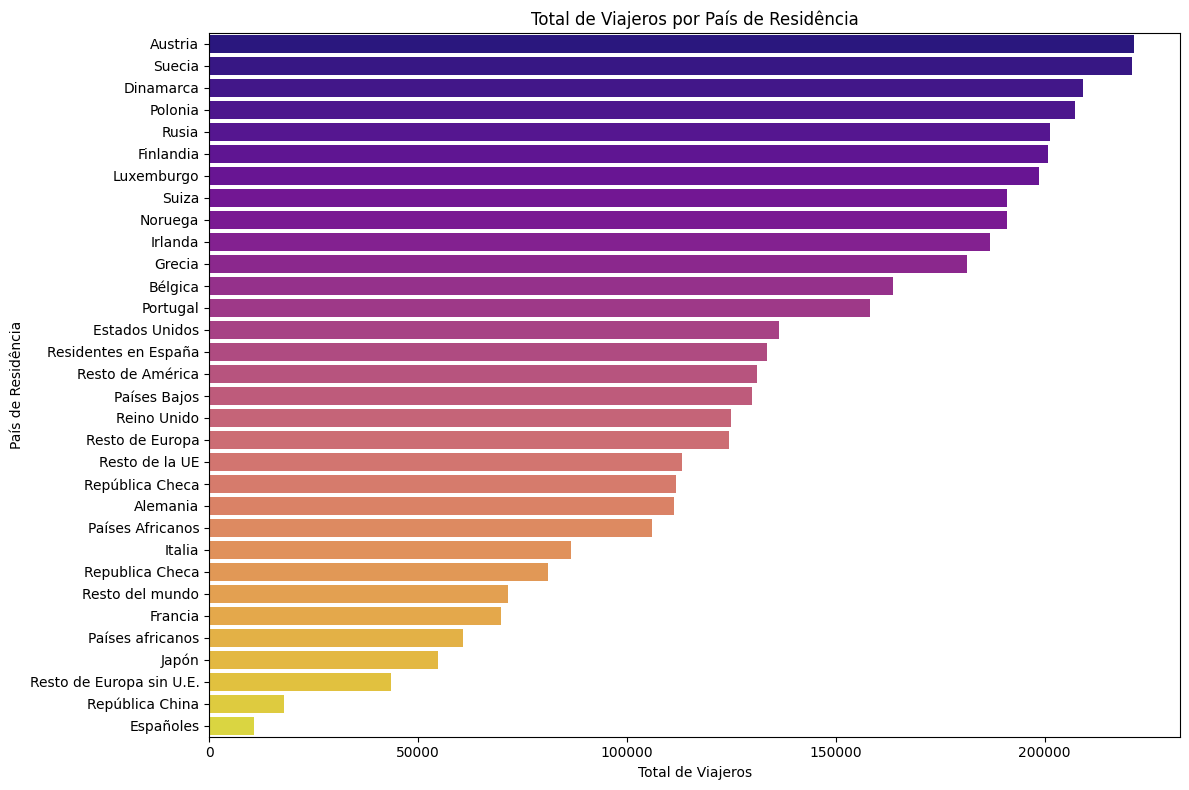

In [35]:
# Gráfico 2: Total de Viajeros por País de Residência 
print("\n--- Gráfico 2: Total de Viajeros por País de Residência ---")
viajeros_por_pais = df_final.groupby('pais_residencia')['total_viajeros'].sum().reset_index()
viajeros_por_pais = viajeros_por_pais.dropna(subset=['total_viajeros'])
viajeros_por_pais['total_viajeros'] = pd.to_numeric(viajeros_por_pais['total_viajeros'], errors='coerce')
viajeros_por_pais = viajeros_por_pais.dropna(subset=['total_viajeros'])
viajeros_por_pais = viajeros_por_pais.sort_values(by='total_viajeros', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=viajeros_por_pais, x='total_viajeros', y='pais_residencia', palette='plasma')
plt.title('Total de Viajeros por País de Residência')
plt.xlabel('Total de Viajeros')
plt.ylabel('País de Residência')
plt.tight_layout() 
plt.show()

Dados resumidos por tipo de acomodação:
  tipo_acomodacion  contagem_filas  total_pernoctaciones_sum  \
0     apartamentos             578                   2873.04   
1          hoteles            1176                   3113.48   

   total_viajeros_sum  
0         2395242.969  
1         1855754.572  


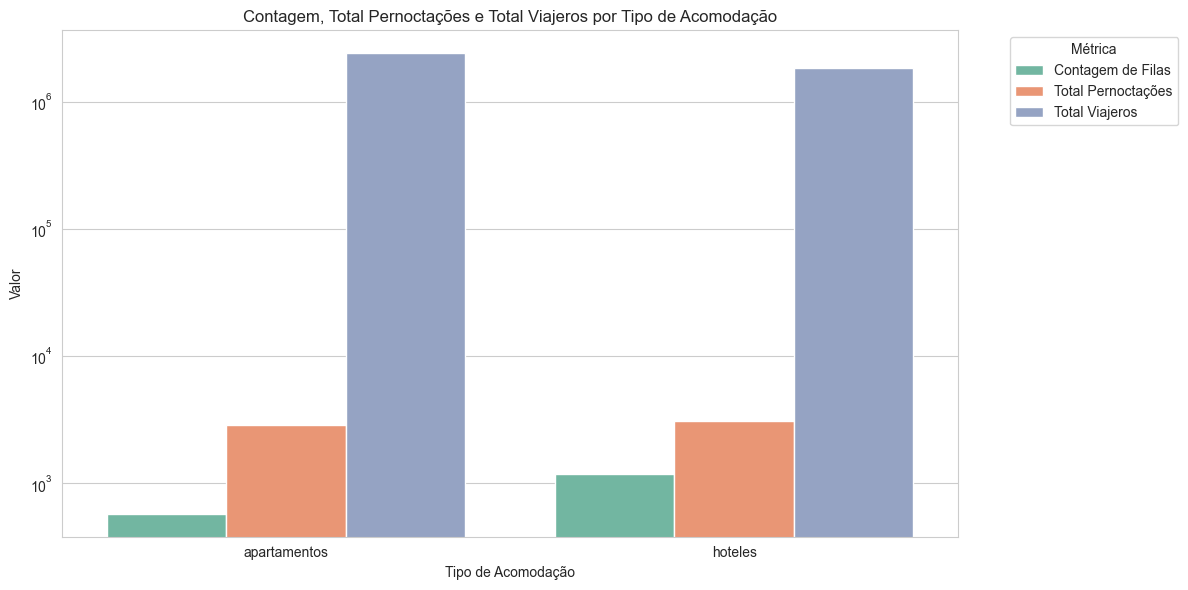

In [43]:
colunas_requeridas = ['tipo_acomodacion', 'total_pernoctaciones', 'total_viajeros']
for col in colunas_requeridas:
    if col not in df_final.columns:
        print(f"Erro: Coluna '{col}' não encontrada no df_final.")
        # Aqui você pode lançar um erro ou retornar, dependendo do seu fluxo
        # raise ValueError(f"Coluna '{col}' não encontrada.")

# Gráfico: Contagem, Total Pernoctações e Total Viajeros por Tipo de Acomodação 
resumo_tipo = df_final.groupby('tipo_acomodacion').agg({
    'total_pernoctaciones': ['count', 'sum'],
    'total_viajeros': 'sum'  
}).reset_index()

resumo_tipo.columns = ['tipo_acomodacion', 'contagem_filas', 'total_pernoctaciones_sum', 'total_viajeros_sum']

print("Dados resumidos por tipo de acomodação:")
print(resumo_tipo)

df_grafico = resumo_tipo.melt(id_vars=['tipo_acomodacion'], 
                              value_vars=['contagem_filas', 'total_pernoctaciones_sum', 'total_viajeros_sum'],
                              var_name='metrica', 
                              value_name='valor')

nome_metricas = {
    'contagem_filas': 'Contagem de Filas',
    'total_pernoctaciones_sum': 'Total Pernoctações',
    'total_viajeros_sum': 'Total Viajeros'
}
df_grafico['metrica_nome'] = df_grafico['metrica'].map(nome_metricas)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_grafico, x='tipo_acomodacion', y='valor', hue='metrica_nome', palette='Set2')
plt.title('Contagem, Total Pernoctações e Total Viajeros por Tipo de Acomodação')
plt.xlabel('Tipo de Acomodação')
plt.ylabel('Valor')
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log') # Usar escala logarítmica no eixo Y para melhor visualização se os valores forem muito diferentes
plt.tight_layout()
plt.show()


--- Gráficos Separados por Métrica ---


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17600\253272996.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumo_tipo, x='tipo_acomodacion', y='contagem_filas', palette='viridis')


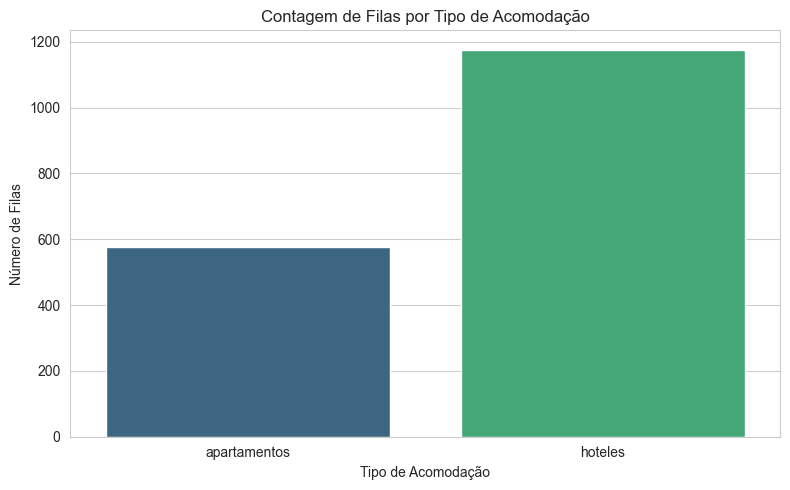

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17600\253272996.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumo_tipo, x='tipo_acomodacion', y='total_pernoctaciones_sum', palette='plasma')


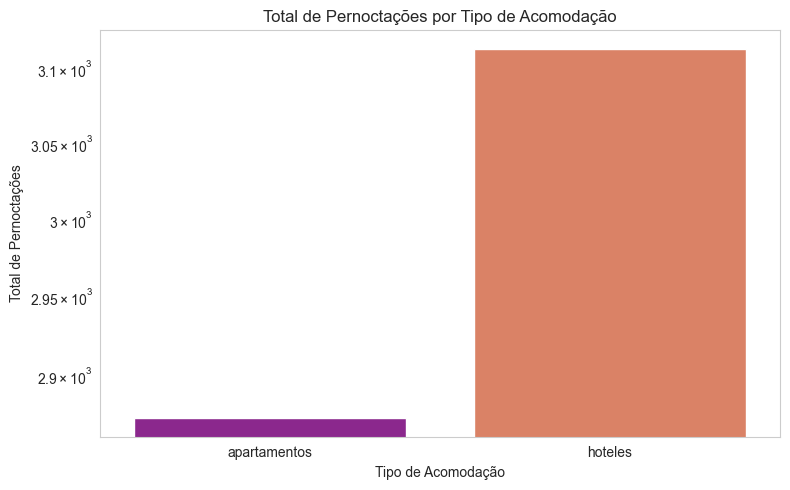

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17600\253272996.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumo_tipo, x='tipo_acomodacion', y='total_viajeros_sum', palette='magma')


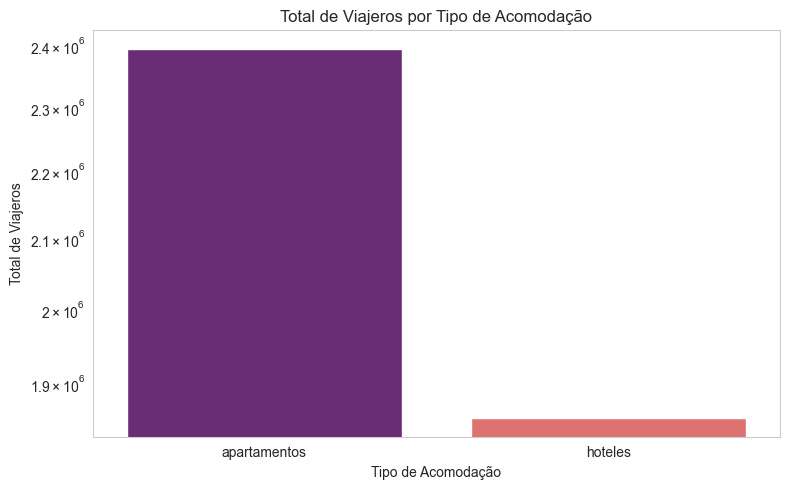

In [44]:
# Gráfico separado para cada métrica
print("\n--- Gráficos Separados por Métrica ---")

# Gráfico 1: Contagem de Filas
plt.figure(figsize=(8, 5))
sns.barplot(data=resumo_tipo, x='tipo_acomodacion', y='contagem_filas', palette='viridis')
plt.title('Contagem de Filas por Tipo de Acomodação')
plt.xlabel('Tipo de Acomodação')
plt.ylabel('Número de Filas')
plt.tight_layout()
plt.show()

# Gráfico 2: Total de Pernoctações
plt.figure(figsize=(8, 5))
sns.barplot(data=resumo_tipo, x='tipo_acomodacion', y='total_pernoctaciones_sum', palette='plasma')
plt.title('Total de Pernoctações por Tipo de Acomodação')
plt.xlabel('Tipo de Acomodação')
plt.ylabel('Total de Pernoctações')
plt.yscale('log') # Escala logarítmica pode ser útil aqui também
plt.tight_layout()
plt.show()

# Gráfico 3: Total de Viajeros
plt.figure(figsize=(8, 5))
sns.barplot(data=resumo_tipo, x='tipo_acomodacion', y='total_viajeros_sum', palette='magma')
plt.title('Total de Viajeros por Tipo de Acomodação')
plt.xlabel('Tipo de Acomodação')
plt.ylabel('Total de Viajeros')
plt.yscale('log') # Escala logarítmica pode ser útil aqui também
plt.tight_layout()
plt.show()


## Análisis estadístico y gráfico de columnas numéricas

Para caracterizar las variables del estudio, se aplicaron las siguientes técnicas:

Prueba de Shapiro-Wilk: Evalúa si una variable sigue una distribución normal. Un valor p < 0,05 indica que no sigue una distribución normal.

Asimetría: Mide la asimetría de la distribución. Los valores altos indican una asimetría significativa.

Método del rango intercuartílico (IQR): Detecta valores atípicos mediante cuartiles:

Un valor atípico se define como cualquier valor inferior a Q1 − 1,5 ⋅ IQR o superior a Q3 + 1,5 ⋅ IQR.

Visualización: Se utilizaron histogramas (con KDE), diagramas de caja y diagramas de dispersión basados ​​en índices para identificar patrones y detectar anomalías.

Este enfoque permite un análisis exhaustivo de las distribuciones de variables, la detección eficaz de valores atípicos y una comprensión más profunda del comportamiento de las soluciones de optimización.

In [36]:
df_final.head()

,año,mes,tipo_acomodacion,provincia,pais_residencia,total_pernoctaciones,total_viajeros
0,2015,Enero,apartamentos,"Balears, Illes",NaN,7.00,NaN
1,2015,Febrero,apartamentos,"Balears, Illes",NaN,6.91,NaN
2,2015,Marzo,apartamentos,"Balears, Illes",NaN,7.06,NaN
3,2015,Abril,apartamentos,"Balears, Illes",NaN,6.26,NaN
4,2015,Mayo,apartamentos,"Balears, Illes",NaN,6.11,NaN


In [49]:
from scipy.stats import shapiro

def analyze_outliers_and_normality(df):
    columns_of_interest = ['total_pernoctaciones', 'total_viajeros']
    missing_cols = [col for col in columns_of_interest if col not in df.columns]
    if missing_cols:
        print(f"Erro: As seguintes colunas não foram encontradas no dataframe: {missing_cols}")
        return None

    # Selecionar apenas as colunas de interesse e fazer uma cópia
    df_clean = df[columns_of_interest].copy()

    # Converter para numérico novamente, caso haja algum valor problemático
    for col in columns_of_interest:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    numeric_columns = df_clean.select_dtypes(include=[np.number]).columns

    if len(numeric_columns) == 0:
        print("Nenhuma coluna numérica encontrada após filtragem.")
        return None

    # Definir limiar para Shapiro-Wilk 
    sample_threshold = 5000
    results = []

    for column in numeric_columns:
        # Excluir valores nulos (NA) ANTES da análise
        data = df_clean[column].dropna()
        n_total = len(df_clean) 
        n_valid = len(data)      

        print(f"\n--- Análise para a coluna: {column} ---")
        print(f"Total de observações no dataframe: {n_total}")
        print(f"Observações válidas (não-NA) para análise: {n_valid}")

        if n_valid == 0:
            print("Coluna está vazia ou contém apenas valores NA.")
            results.append({
                'Column': column,
                'Sample_Size': 0,
                'Skewness': np.nan,
                'Shapiro_p': 'Not applicable',
                'Normal': 'Not applicable',
                'Outliers': 0,
                'Outlier_Percentage': 0.0
            })
            continue

        # Avaliação de Normalidade
        skewness = data.skew()
        p_value = np.nan
        is_normal = None
        shapiro_info = ""

        if n_valid < 3:
            print("Amostra muito pequena para análise.")
            is_normal = False
            shapiro_info = "Not applicable"
        elif n_valid < sample_threshold:
            try:
                stat, p_value = shapiro(data)
                is_normal = p_value > 0.05
                shapiro_info = f"p = {p_value:.4f}"
            except Exception as e:
                print(f"Falha no Shapiro-Wilk: {e}")
                is_normal = abs(skewness) < 0.5
                shapiro_info = "Error"
        else:
            is_normal = abs(skewness) < 0.5
            shapiro_info = f"Ignorado (n > {sample_threshold})"

        print(f"Shapiro-Wilk: {shapiro_info}")
        print(f"Skewness: {skewness:.3f}")

        # Detecção de Outliers (Método IQR)
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Contar outliers no dataframe original (antes da exclusão de NA)
        # Isso é importante para o cálculo de porcentagem relativo ao total
        n_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        outlier_percentage = (n_outliers / n_total) * 100 # Usando n_total do dataframe original

        print(f"Outliers (IQR, relativo ao total): {n_outliers} ({outlier_percentage:.1f}%)")
        print(f"Limites (IQR): [{lower_bound:.3f}, {upper_bound:.3f}]")

        # Mostrar valores de outliers (apenas os que não são NA e são outliers)
        outliers_data = df[(df[column].notna()) & ((df[column] < lower_bound) | (df[column] > upper_bound))][column]
        if len(outliers_data) > 0:
            print("\n   Valores de outlier (não-NA):")
            print(outliers_data.to_string(index=True))

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        sns.histplot(data, kde=True, bins=25, ax=axes[0], color='skyblue', alpha=0.8)
        axes[0].axvline(lower_bound, color='red', linestyle='--', linewidth=1.2,
                        label=f'Limite inferior: {lower_bound:.2f}')
        axes[0].axvline(upper_bound, color='red', linestyle='--', linewidth=1.2,
                        label=f'Limite superior: {upper_bound:.2f}')
        axes[0].set_title(f'Distribuição de {column}')
        axes[0].legend(fontsize=9)

        sns.boxplot(y=data, ax=axes[1], color='salmon')
        axes[1].set_title(f'Boxplot de {column}')
        df_plot = df.reset_index() 
        outlier_mask = (df_plot[column].notna()) & ((df_plot[column] < lower_bound) | (df_plot[column] > upper_bound))
        colors = ['red' if is_outlier else 'gray' for is_outlier in outlier_mask]
        axes[2].scatter(df_plot.index, df_plot[column], c=colors, s=25, alpha=0.7)
        axes[2].axhline(lower_bound, color='red', linestyle='--', linewidth=1, label='Limite IQR')
        axes[2].axhline(upper_bound, color='red', linestyle='--', linewidth=1)
        axes[2].set_title(f'{column} por Índice (outliers em vermelho)')
        axes[2].set_xlabel('Índice')
        axes[2].set_ylabel(column)
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        # Armazenar resultados
        results.append({
            'Column': column,
            'Sample_Size': n_valid, 
            'Skewness': round(skewness, 3),
            'Shapiro_p': round(p_value, 4) if not pd.isna(p_value) else shapiro_info,
            'Normal': 'Yes' if is_normal else 'No' if is_normal is not None else 'Not evaluated',
            'Outliers': n_outliers, # Contagem total de outliers no dataframe original
            'Outlier_Percentage': round(outlier_percentage, 1) # Porcentagem relativa ao total
        })

    # Resumo Final (fora do loop!)
    df_summary = pd.DataFrame(results)
    df_display = df_summary.copy()
    df_display['Outlier_Percentage'] = df_display['Outlier_Percentage'].astype(str) + '%'

    # Imprimir tabela completa
    print("\n--- Resumo da Análise ---")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        print(df_display.to_string(index=False))

    return df_summary


--- Análise para a coluna: total_pernoctaciones ---
Total de observações no dataframe: 31836
Observações válidas (não-NA) para análise: 1754
Shapiro-Wilk: p = 0.0000
Skewness: 3.429
Outliers (IQR, relativo ao total): 52 (0.2%)
Limites (IQR): [-1.175, 7.505]

   Valores de outlier (não-NA):
7         7.78
9         8.06
30        8.21
31        8.70
32        8.75
78        8.78
79        9.14
84       10.20
94        8.25
115       9.50
116       7.75
162       8.68
163       9.90
178       7.97
180       8.13
199       7.93
246       7.94
247       9.16
252       8.65
264       8.11
283       8.28
330       7.85
331       8.35
336       9.48
367       7.98
420       7.86
422       9.31
432       7.78
434      16.07
436      21.63
440       7.81
441      12.18
442      21.38
443      24.61
465       7.54
466       7.73
467       7.74
502       7.89
504       7.86
506       9.31
516       7.78
518      16.07
520      21.63
524       7.81
525      12.18
526      21.38
527      24.61
549

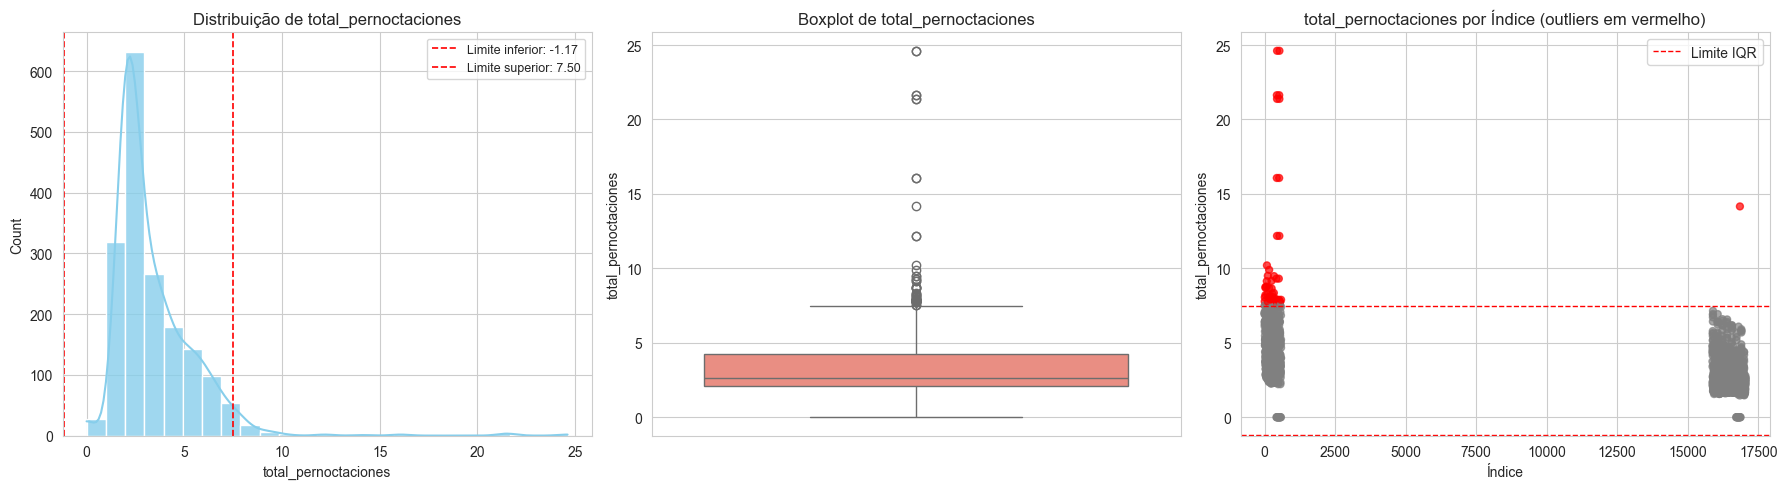


--- Análise para a coluna: total_viajeros ---
Total de observações no dataframe: 31836
Observações válidas (não-NA) para análise: 27713
Shapiro-Wilk: Ignorado (n > 5000)
Skewness: 1.772
Outliers (IQR, relativo ao total): 3128 (9.8%)
Limites (IQR): [-304.230, 516.938]

   Valores de outlier (não-NA):
620      960.000
639      786.000
652      585.000
653      681.000
655      687.000
656      694.000
663      520.000
714      627.000
715      666.000
736      732.000
738      976.000
749      650.000
750      991.000
751      988.000
766      924.000
767      666.000
772      527.000
774      816.000
796      957.000
801      706.000
813      732.000
822      959.000
824      963.000
825      611.000
831      763.000
844      524.000
847      740.000
848      658.000
856      954.000
860      839.000
868      567.000
869      609.000
870      854.000
872      748.000
883      678.000
891      597.000
892      783.000
897      571.000
912      769.000
922      797.000
923      729.000
9

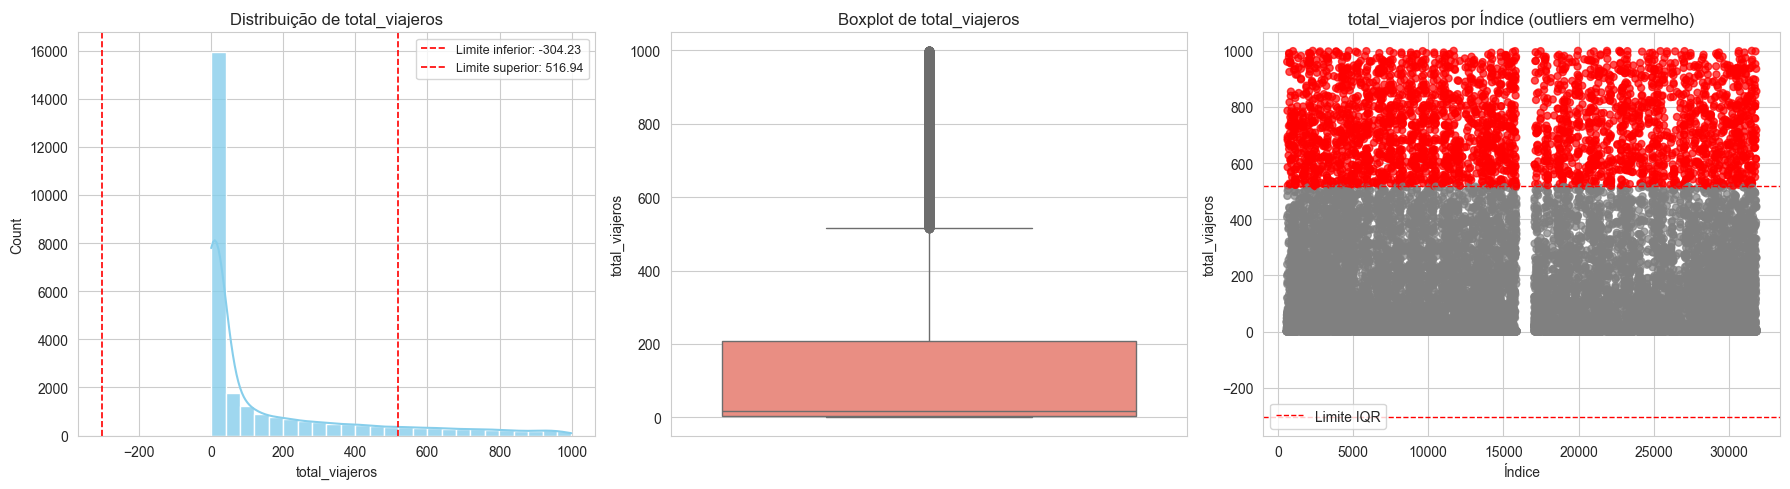


--- Resumo da Análise ---
              Column  Sample_Size  Skewness           Shapiro_p Normal  Outliers Outlier_Percentage
total_pernoctaciones         1754     3.429                 0.0     No        52               0.2%
      total_viajeros        27713     1.772 Ignorado (n > 5000)     No      3128               9.8%


In [50]:
df_summary = analyze_outliers_and_normality(df_final)

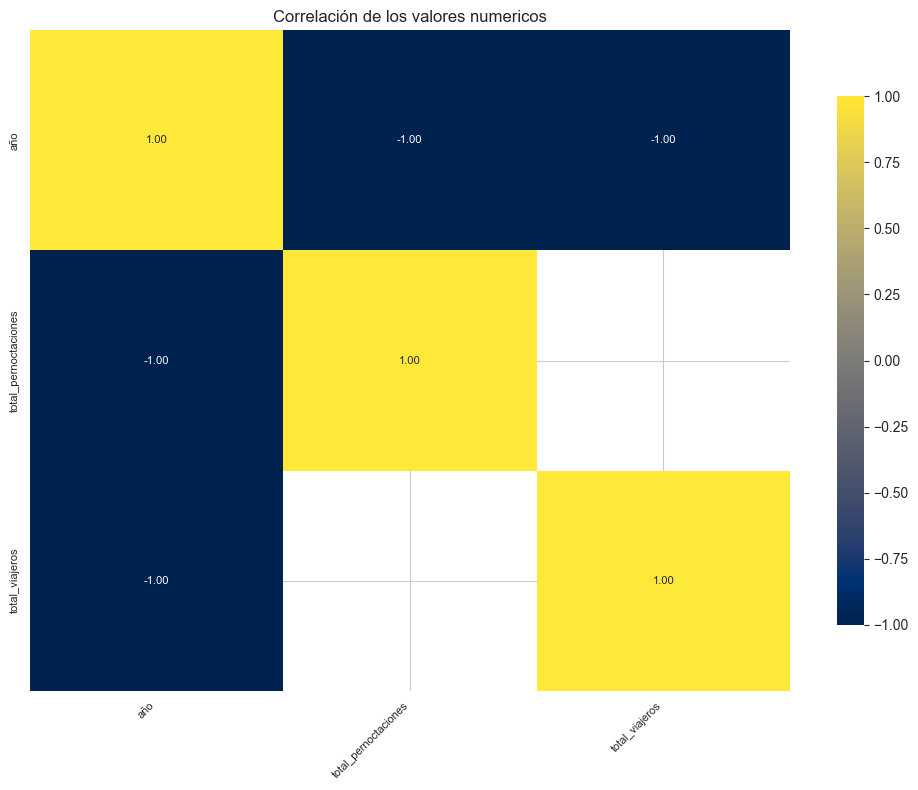

In [45]:
numeric_df = df_final.select_dtypes(include=['number'])
corr_pearson = numeric_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
   corr_pearson.corr(),
    annot=True,
    cmap='cividis',
    fmt=".2f",                      # limits to 2 decimals
    annot_kws={"size": 8},          # controls number text size
    cbar_kws={"shrink": 0.8}        # makes colorbar smaller
)
plt.title(
    'Correlación de los valores numericos',
    fontsize=12                     # smaller title
)
plt.xticks(fontsize=8, rotation=45, ha='right')  # smaller rotated labels
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()